In [5]:
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
ep = 0.00001

##--------------------Data Preprocesseing -------------------------------

Train_X = []
Train_Y = []
y=0
for a,b,file in os.walk("horse-or-human/train"):
    for i in file:
        str1 = a+"/"+str(i)
        t = cv2.imread(str1)
        t = cv2.cvtColor(t,cv2.COLOR_BGR2GRAY)
        t = t/255
        t = t.reshape(10000)
        Train_X.append(t)
        Train_Y.append(y-1)
    y+=1

Test_X = []
Test_Y = []
y=0
for a,b,file in os.walk("horse-or-human/validation"):
    for i in file:
        str1 = a+"/"+str(i)
        t = cv2.imread(str1)
        t = cv2.cvtColor(t,cv2.COLOR_BGR2GRAY)
        t = t/255
        t = t.reshape(10000)  #vectorization
        Test_X.append(t)
        Test_Y.append(y-1)
    y+=1
print("loading the train img Complete : %d"%(len(Train_X)))
print("loading the validation img Complete : %d"%(len(Test_X)))

#------------------------ function definition------------------------------------

def sigmoid(z):
    return 1/(1+np.exp(-z))

def gradient_decent_vectorization(w,b,rate):
    w = np.asarray(w).reshape(len(Train_X[0]))
    x = np.asarray(Train_X).T
    oz = sigmoid(np.matmul(w,x)+b)  # x : 10000 X 1027 matrix,    oz : 1027 vector
    nw = w - rate*(1/len(Train_X[0]))*np.matmul(x,oz-Train_Y)
    nb = b - rate*(1/len(Train_X[0]))*np.sum(oz-Train_Y)
    return (nw,nb)

def cross_entropy(py,y):
    sum = 0
    for i in range(len(py)):
        sum += -y[i]*np.log(py[i]+ep)-(1-y[i])*np.log(1-py[i]+ep)
    return sum/len(py)

def data_forward(prevX,w,b):  # 다음층 전달
    w = np.asarray(w)
    x = np.asarray(prevX).T
    return sigmoid(np.matmul(w,x)+b)


def back_propagation(W1,W2,W3,b1,b2,b3,X1,X2,X3,rate):
    loss3 = (1/len(X3))*np.matmul(X2,X3-Train_Y)
    nW3 = W3 - rate * loss3                            # 출력층 가중치 업데이트
    nb3 = b3 - rate * (1/len(X3))*np.sum(X3-Train_Y)   # 출력층 바이어스 업데이트
    X2 = np.asarray(X2)
    X1 = np.asarray(X1)
    print("loss3 :")
    print(np.asarray(loss3).shape)
    loss2 = float(np.matmul(loss3,W3.T))*np.asarray(np.matmul(X2.T,1-X2))
    loss2 = np.asarray(loss2)
    print("loss2 :")
    print(loss2.shape)
    loss1 = float(np.matmul(loss3, W3.T)) * np.asarray(np.matmul(X2.T, 1 - X2))
    loss1 = np.asarray(loss2)
    print("loss2 :")
    print(loss2.shape)
    return (W1,W2,nW3,b1,b2,nb3)


#----------------------- ready to learning ----------------------------------

np.random.seed(3)
w = np.random.normal(0.000001,0.000009,10000)

b = 3.5
rate = 0.022
epoches = 2000

Train_Acc = []
Train_Loss = []
Val_Acc = []
Val_Loss = []


nodesize = 10
w1 = []
w2 = []
w3 = np.random.normal(0.000001,0.000009,nodesize)  # 출력층 가중치

for i in range(nodesize):
    w1.append(np.random.normal(0.000001,0.000009,10000))
    w2.append(np.random.normal(0.000001,0.000009,nodesize))

b = 4
b1 = 4
b2 = 3
b3 = 2

rate = 0.021

X1 = []   # 첫번째 층의 결과 X1 = sigmoid(TrainX*W1 + b1)
X2 = []   # 두번째 층의 결과 X2 = sigmoid(X1*W2 + b2)
X3 = []   # 출력 층의 결과 X3 = sigmoid(X2*W3 + b3)

print("초기 input shape")
print(np.asarray(Train_X).T.shape)
print("초기 weight1 shape")
print(np.asarray(w1).shape)
print("초기 weight2 shape")
print(np.asarray(w2).shape)
print("초기 weight3 shape")
print(np.asarray(w3).shape)
# ---------------------------------------learning ----------------------------------------------------------------

pastTime = time.time()
for i in range(epoches):
    x = np.asarray(Train_X).T
    (nw,nb) = gradient_decent_vectorization(w,b,rate)
    w = nw
    b = nb

    # input ==== > layer 1 (out : X1)
    for m in range(nodesize):
        X1=np.asarray(X1)
        X1.append(data_forward(Train_X, w1[i], b1))
    #print(np.asarray(X1).T.shape)

    # layer 1 ==== > layer 2 (out : X2)
    for n in range(nodesize):
        X1 = np.asarray(X1)
        X2.append(data_forward(np.asarray(X1).T, w2[i], b2))
    #print(np.asarray(X2).T.shape)

    # layer 2 ==== > Output Layer (out : X3)
    X1 = np.asarray(X1)
    X3 = data_forward(np.asarray(X2).T, w3, b3)
    #print(np.asarray(X3).T.shape)

    back_propagation(w1, w2, w3, b1, b2, b3, X1, X2, X3, rate)  # 역전파
    (nw1, nw2, nw3, nb1, nb2, nb3) = back_propagation(w1, w2, w3, b1, b2, b3, X1, X2, X3, rate)
    w1 = nw1
    w2 = nw2
    w3 = nw3
    b1 = nb1
    b2 = nb2
    b3 = nb3

    #--- Train Cal------------------------------------
    x = np.asarray(Train_X).T
    predict_y = sigmoid(np.matmul(w,x)+b)
    train_loss = cross_entropy(predict_y,Train_Y)
    Train_Loss.append([i,train_loss])

    for j in range(len(predict_y)):
        if predict_y[j] > 0.5:
            predict_y[j] = 1
        else:
            predict_y[j] = 0

    acc_count=0
    for k in range(len(predict_y)):
        if predict_y[k] == Train_Y[k]:
            acc_count+=1
    train_acc = acc_count/len(predict_y)
    Train_Acc.append([i,train_acc])

    #--- Validation Cal ------------------------------
    vx = np.asarray(Test_X).T
    vpredict_y = sigmoid(np.matmul(w, vx) + b)
    test_loss = cross_entropy(vpredict_y, Test_Y)
    Val_Loss.append([i,test_loss])

    for j in range(len(vpredict_y)):
        if vpredict_y[j] > 0.5:
            vpredict_y[j] = 1
        else:
           vpredict_y[j] = 0

    acc_count=0
    for l in range(len(vpredict_y)):
        if vpredict_y[l] == Test_Y[l]:
            acc_count+=1
    test_acc = acc_count/len(vpredict_y)
    Val_Acc.append([i,test_acc])

    #---------------------------------------------------
    if i%100 ==0 :
        print("epoch: %d , Train_loss : %f, TrainAcc : %f , Val loss : %f , Val acc : %f, time : %0.5fs" % (i,train_loss,train_acc,test_loss,test_acc,time.time()-pastTime))
        pastTime = time.time()


loading the train img Complete : 1027
loading the validation img Complete : 256
초기 input shape
(10000, 1027)
초기 weight1 shape
(10, 10000)
초기 weight2 shape
(10, 10)
초기 weight3 shape
(10,)
epoch: 0 , Train_loss : 1.048729, TrainAcc : 0.507303 , Val loss : 0.742474 , Val acc : 0.414062, time : 0.15237s
epoch: 100 , Train_loss : 0.706084, TrainAcc : 0.686465 , Val loss : 0.660894 , Val acc : 0.593750, time : 15.89378s
epoch: 200 , Train_loss : 0.632755, TrainAcc : 0.710808 , Val loss : 0.532263 , Val acc : 0.648438, time : 17.56176s
epoch: 300 , Train_loss : 0.589270, TrainAcc : 0.725414 , Val loss : 0.477603 , Val acc : 0.707031, time : 16.36807s
epoch: 400 , Train_loss : 0.557700, TrainAcc : 0.740019 , Val loss : 0.450881 , Val acc : 0.738281, time : 16.25893s
epoch: 500 , Train_loss : 0.532651, TrainAcc : 0.749757 , Val loss : 0.437004 , Val acc : 0.753906, time : 16.12812s
epoch: 600 , Train_loss : 0.511789, TrainAcc : 0.761441 , Val loss : 0.429891 , Val acc : 0.761719, time : 16.8726

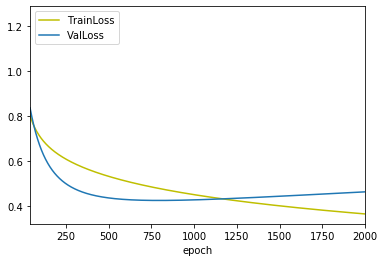

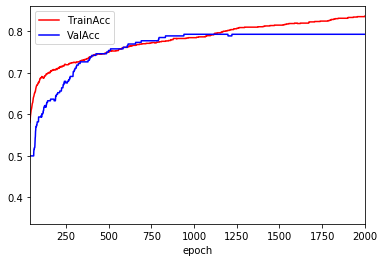

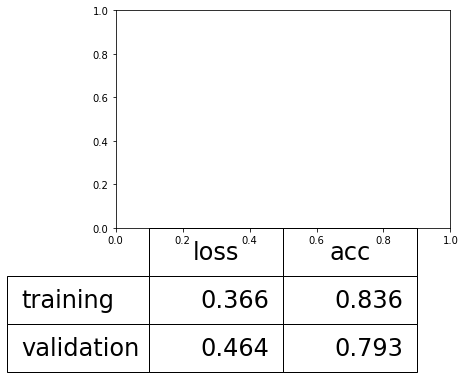

In [6]:
#--------------------------result plot ---------------------------------

listOfTrainLoss = np.asarray(Train_Loss)
listOfTrainAcc = np.asarray(Train_Acc)
listOfTestLoss = np.asarray(Val_Loss)
listOfTestAcc = np.asarray(Val_Acc)
plt.xlabel('epoch')
plt.xlim(40,epoches)
plt.plot(listOfTrainLoss[:,0],listOfTrainLoss[:,1],c="y",label='TrainLoss')
plt.plot(listOfTestLoss[:,0],listOfTestLoss[:,1],label='ValLoss')
plt.legend(loc="upper left")
plt.show()
plt.xlabel('epoch')
plt.xlim(40,epoches)
plt.plot(listOfTrainAcc[:,0],listOfTrainAcc[:,1],c="r",label='TrainAcc')
plt.plot(listOfTestAcc[:,0],listOfTestAcc[:,1],c="b",label='ValAcc')
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
col_labels = ['loss', 'acc']
row_labels = ['training', 'validation']
table_vals = [[round(Train_Loss[epoches-1][1],3),round(Train_Acc[epoches-1][1],3)],[round(Val_Loss[epoches-1][1],3),round(Val_Acc[epoches-1][1],3)]]

the_table = plt.table(cellText=table_vals,colWidths=[0.1] * 2,rowLabels=row_labels,colLabels=col_labels)
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4, 4)
plt.show()